In [4]:
# pip install pandas numpy nibabel scipy scikit-image scikit-learn torch torchvision matplotlib seaborn mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 13.0 MB/s eta 0:00:00m eta 0:00:01:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os

def count_folders(base_path):
    """
    Counts the number of folders inside the given base_path.
    Prints the folder names and returns the count.
    """
    try:
        # List all entries in the base path
        entries = os.listdir(base_path)
        
        # Filter only directories
        folders = [entry for entry in entries if os.path.isdir(os.path.join(base_path, entry))]
        
        # Print folder names
        print(f"Folders inside '{base_path}':")
        for folder in folders:
            print(f"- {folder}")
        
        # Return the count of folders
        return len(folders)
    except Exception as e:
        print(f"Error accessing {base_path}: {e}")
        return 0

# Example usage
base_path = "Control Imgs"  # Replace with the path to your folder
folder_count = count_folders(base_path)
print(f"\nTotal number of folders inside '{base_path}': {folder_count}")

Folders inside 'Control Imgs':
- 3157
- 3161
- 3551
- 3300
- 3569
- 3104
- 3160
- 3151
- 3169
- 3390
- 3301
- 3765
- 4067
- 3816
- 3811
- 4004
- 3817
- 4032
- 3804
- 4010
- 3803
- 3850
- 4018
- 3805
- 3572
- 4139
- 3370
- 3779
- 3188
- 3172
- 3767
- 3555
- 3756
- 3769
- 3563
- 3368
- 3191
- 3165
- 3750
- 3106
- 3565
- 3768
- 3554
- 3759
- 3369
- 3812
- 3813
- 4085
- 3853
- 3854
- 3807
- 3809
- 3855
- 3852
- 3806
- 3389
- 3112
- 3320
- 3115
- 3571
- 3316
- 3171
- 3310
- 3114
- 3570

Total number of folders inside 'Control Imgs': 65


In [11]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import mahotas as mh

# Paths
control_imgs_path = "Control Imgs"  # Path to Control Imgs folder
pd_imgs_path = "PD Imgs"            # Path to PD Imgs folder

# Function to extract features from .nii images
def extract_features_from_nii(image_path):
    img = nib.load(image_path).get_fdata()
    
    # Resize to consistent shape (e.g., 64x64x64)
    img_resized = np.resize(img, (64, 64, 64))
    
    # Normalize pixel intensities
    img_normalized = (img_resized - np.mean(img_resized)) / np.std(img_resized)
    
    # Extract statistical features
    mean_intensity = np.mean(img_normalized)
    std_intensity = np.std(img_normalized)
    skewness = np.mean((img_normalized - mean_intensity)**3) / (std_intensity**3)
    kurtosis = np.mean((img_normalized - mean_intensity)**4) / (std_intensity**4)
    
    # Extract texture features using Mahotas Haralick features
    haralick_features = mh.features.haralick((img_normalized * 255).astype(np.uint8)).mean(axis=0)
    
    # Combine all features
    return [mean_intensity, std_intensity, skewness, kurtosis] + list(haralick_features)

# Process images and extract features
features = []
subject_ids = []
labels = []

# Function to process a folder structure
def process_folder_structure(base_path, label):
    for subject_folder in os.listdir(base_path):  # Iterate over subject folders (e.g., 3157, 3551)
        subject_path = os.path.join(base_path, subject_folder)
        if os.path.isdir(subject_path):
            for subfolder in os.listdir(subject_path):  # Iterate over subfolders (e.g., T1-anatomical, T2_in_corrected_EPI_space)
                subfolder_path = os.path.join(subject_path, subfolder)
                if os.path.isdir(subfolder_path):
                    for date_folder in os.listdir(subfolder_path):  # Iterate over date folders (e.g., 2011-02-07_10_44_54.0)
                        date_folder_path = os.path.join(subfolder_path, date_folder)
                        if os.path.isdir(date_folder_path):
                            for nii_folder in os.listdir(date_folder_path):  # Iterate over folders containing .nii files
                                nii_folder_path = os.path.join(date_folder_path, nii_folder)
                                if os.path.isdir(nii_folder_path):
                                    for file in os.listdir(nii_folder_path):  # Iterate over .nii files
                                        if file.endswith('.nii'):
                                            file_path = os.path.join(nii_folder_path, file)
                                            print(f"Processing file: {file_path}")  # Debugging line
                                            
                                            # Extract features
                                            try:
                                                feature_vector = extract_features_from_nii(file_path)
                                                features.append(feature_vector)
                                                
                                                # Add Subject ID (PATNO) and Label
                                                subject_id = int(subject_folder)  # Subject ID is the folder name (e.g., 3157, 3551)
                                                subject_ids.append(subject_id)
                                                labels.append(label)
                                            except Exception as e:
                                                print(f"Error processing file {file_path}: {e}")

# Process Control and PD images
process_folder_structure(control_imgs_path, "Control")
process_folder_structure(pd_imgs_path, "PD")

# Create a DataFrame for features
haralick_columns = [f'Haralick_{i}' for i in range(13)]  # Mahotas Haralick features have 13 components
columns = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + haralick_columns
features_df = pd.DataFrame(features, columns=columns)
features_df['PATNO'] = subject_ids  # Add Subject ID column
features_df['Label'] = labels       # Add Label column

# Save to CSV
features_df.to_csv('extracted_features.csv', index=False)
print("Feature extraction complete. Saved to 'extracted_features.csv'.")

Processing file: Control Imgs/3157/T2_in_corrected_EPI_space_for_I243695/2011-02-07_10_44_54.0/I292146/PPMI_3157_MR_T2_in_corrected_EPI_space_for_I243695_Br_20120322175118738_S113898_I292146.nii
Processing file: Control Imgs/3157/T2_in_corrected_EPI_space_for_I243706/2011-02-07_10_44_54.0/I292157/PPMI_3157_MR_T2_in_corrected_EPI_space_for_I243706_Br_20120322175420343_S113898_I292157.nii
Processing file: Control Imgs/3157/T1-anatomical/2011-02-07_10_44_54.0/I330706/PPMI_3157_MR_T1-anatomical_Br_20120905125112395_S113900_I330706.nii
Processing file: Control Imgs/3157/T2_in_T1-anatomical_space/2011-02-07_10_44_54.0/I330705/PPMI_3157_MR_T2_in_T1-anatomical_space_Br_20120905125102713_S113900_I330705.nii
Processing file: Control Imgs/3161/T2_in_corrected_EPI_space_for_I249257/2011-07-28_10_52_10.0/I292201/PPMI_3161_MR_T2_in_corrected_EPI_space_for_I249257_Br_20120322180703469_S117821_I292201.nii
Processing file: Control Imgs/3161/T2_in_corrected_EPI_space_for_I249256/2011-07-28_10_52_10.0/I2

/var/folders/nz/5q60qqc14xd9gns7mp3gm83w0000gp/T/ipykernel_56193/1998175902.py:19: RuntimeWarning: invalid value encountered in divide
  img_normalized = (img_resized - np.mean(img_resized)) / np.std(img_resized)
/var/folders/nz/5q60qqc14xd9gns7mp3gm83w0000gp/T/ipykernel_56193/1998175902.py:28: RuntimeWarning: invalid value encountered in cast
  haralick_features = mh.features.haralick((img_normalized * 255).astype(np.uint8)).mean(axis=0)


Processing file: Control Imgs/3106/T2_in_corrected_EPI_space_for_I235248/2011-03-24_14_13_48.0/I305093/PPMI_3106_MR_T2_in_corrected_EPI_space_for_I235248_Br_20120517110939825_S109068_I305093.nii
Processing file: Control Imgs/3106/T1-anatomical/2011-03-24_14_13_48.0/I330427/PPMI_3106_MR_T1-anatomical_Br_20120905113341612_S109071_I330427.nii
Processing file: Control Imgs/3106/T2_in_corrected_EPI_space_for_I235250/2011-03-24_14_13_48.0/I406367/PPMI_3106_MR_T2_in_corrected_EPI_space_for_I235250_Br_20140123120731437_S109068_I406367.nii
Processing file: Control Imgs/3106/T2_in_T1-anatomical_space/2011-03-24_14_13_48.0/I330426/PPMI_3106_MR_T2_in_T1-anatomical_space_Br_20120905113330263_S109071_I330426.nii
Processing file: Control Imgs/3565/T2_in_corrected_EPI_space_for_I249268/2011-06-15_08_59_25.0/I292865/PPMI_3565_MR_T2_in_corrected_EPI_space_for_I249268_Br_20120323205211448_S117836_I292865.nii
Processing file: Control Imgs/3565/T2_in_corrected_EPI_space_for_I249269/2011-06-15_08_59_25.0/I2

In [16]:
pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the datasets
image_features = pd.read_csv('extracted_features.csv')  # Load extracted image features
clinical_features = pd.read_csv('Final_clinical_feat.csv')  # Load clinical features

# Merge datasets on PATNO
merged_data = pd.merge(image_features, clinical_features, on='PATNO')

# Separate image and clinical feature columns
image_columns = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis'] + [f'Haralick_{i}' for i in range(13)]
clinical_columns = clinical_features.columns[1:-1]  # Exclude PATNO and COHORT_DEFINITION (label)

# Extract labels
labels = merged_data['Label']  # From extracted_features.csv
# Alternatively, if you want to use the clinical label:
# labels = merged_data['COHORT_DEFINITION']

# Normalize image and clinical features
scaler = StandardScaler()
merged_data[image_columns] = scaler.fit_transform(merged_data[image_columns])  # Normalize image features
merged_data[clinical_columns] = scaler.fit_transform(merged_data[clinical_columns])  # Normalize clinical features

# Display the first few rows of the merged and preprocessed data
print(merged_data.head())

   Mean_Intensity  Std_Intensity  Skewness  Kurtosis  Haralick_0  Haralick_1  \
0        2.024669   2.220446e-16 -0.410778 -0.475119    2.177695   -1.140013   
1       -0.906719   0.000000e+00 -0.414580 -0.476375    2.164144   -1.133263   
2       -0.061127   0.000000e+00  0.105968 -0.243473   -1.097994   -0.410737   
3       -0.183268   0.000000e+00  2.268339  1.738265   -0.148068    1.577977   
4        0.371065   2.220446e-16 -0.430296 -0.475958    0.789496   -1.135313   

   Haralick_2  Haralick_3  Haralick_4  Haralick_5  ...   NP2DRES   NP2SPCH  \
0   -0.481638   -1.162730    1.703883    0.956470  ... -0.561822 -0.515391   
1   -0.494413   -1.156831    1.695931    0.952715  ... -0.561822 -0.515391   
2   -0.460076   -0.452758   -1.434596    1.270898  ... -0.561822 -0.515391   
3    1.592984    2.045037   -0.007204    0.658291  ... -0.561822 -0.515391   
4   -0.061589   -1.138492    0.999829    0.883434  ... -0.561822 -0.515391   

     NP2EAT   NP2SALV    NP1COG   NP2SWAL   NP1ANX

In [62]:
# Check for missing values in the merged dataset
print(merged_data.isnull().sum())

Mean_Intensity       2
Std_Intensity        2
Skewness             2
Kurtosis             2
Haralick_0           0
Haralick_1           0
Haralick_2           0
Haralick_3           0
Haralick_4           0
Haralick_5           0
Haralick_6           0
Haralick_7           0
Haralick_8           0
Haralick_9           0
Haralick_10          0
Haralick_11          0
Haralick_12          0
PATNO                0
Label                0
NP3TOT               0
NP3GAIT              0
NP3SPCH              0
NP2DRES              0
NP2SPCH              0
NP2EAT               0
NP2SALV              0
NP1COG               0
NP2SWAL              0
NP1ANXS              0
NP1APAT              0
NP1DPRS              0
COHORT_DEFINITION    0
dtype: int64


In [63]:
# Fill missing values in specific columns with their median
columns_with_missing_values = ['Mean_Intensity', 'Std_Intensity', 'Skewness', 'Kurtosis']

for col in columns_with_missing_values:
    median_value = merged_data[col].median()  # Calculate the median of the column
    merged_data[col] = merged_data[col].fillna(median_value)  # Assign the filled column back to the DataFrame

# Verify that there are no more missing values
print(merged_data.isnull().sum())

Mean_Intensity       0
Std_Intensity        0
Skewness             0
Kurtosis             0
Haralick_0           0
Haralick_1           0
Haralick_2           0
Haralick_3           0
Haralick_4           0
Haralick_5           0
Haralick_6           0
Haralick_7           0
Haralick_8           0
Haralick_9           0
Haralick_10          0
Haralick_11          0
Haralick_12          0
PATNO                0
Label                0
NP3TOT               0
NP3GAIT              0
NP3SPCH              0
NP2DRES              0
NP2SPCH              0
NP2EAT               0
NP2SALV              0
NP1COG               0
NP2SWAL              0
NP1ANXS              0
NP1APAT              0
NP1DPRS              0
COHORT_DEFINITION    0
dtype: int64


In [64]:
import numpy as np
from sklearn.neighbors import kneighbors_graph

# Define the number of neighbors for KNN
K = 5

# Extract image and clinical feature matrices
image_features_matrix = merged_data[image_columns].values  # Image features
clinical_features_matrix = merged_data[clinical_columns].values  # Clinical features

# Construct adjacency matrices using KNN
Am = kneighbors_graph(image_features_matrix, n_neighbors=K, mode='connectivity', include_self=True).toarray()
Af = kneighbors_graph(clinical_features_matrix, n_neighbors=K, mode='connectivity', include_self=True).toarray()

# Add self-loops to adjacency matrices
Am = Am + np.eye(Am.shape[0])  # Self-loop for image graph
Af = Af + np.eye(Af.shape[0])  # Self-loop for clinical graph

# Display the adjacency matrices
print("Image Graph Adjacency Matrix (Am):")
print(Am)

print("\nClinical Graph Adjacency Matrix (Af):")
print(Af)

Image Graph Adjacency Matrix (Am):
[[2. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 1. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 2. 0.]
 [0. 0. 0. ... 0. 0. 2.]]

Clinical Graph Adjacency Matrix (Af):
[[2. 1. 1. ... 0. 0. 0.]
 [1. 2. 1. ... 0. 0. 0.]
 [1. 1. 2. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 1. 1.]
 [0. 0. 0. ... 1. 2. 1.]
 [0. 0. 0. ... 1. 1. 2.]]


In [65]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [66]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

# Convert adjacency matrices and feature matrices to PyTorch Geometric format
image_graph = Data(
    x=torch.tensor(image_features_matrix, dtype=torch.float),  # Node features for the image graph
    edge_index=torch.tensor(np.array(np.nonzero(Am)), dtype=torch.long)  # Edge index for the image graph
)

clinical_graph = Data(
    x=torch.tensor(clinical_features_matrix, dtype=torch.float),  # Node features for the clinical graph
    edge_index=torch.tensor(np.array(np.nonzero(Af)), dtype=torch.long)  # Edge index for the clinical graph
)

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, 16, heads=4, concat=True)  # First GAT layer
        self.gat2 = GATConv(16 * 4, out_channels, heads=1, concat=False)  # Second GAT layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)  # Apply first GAT layer
        x = torch.relu(x)  # Apply ReLU activation
        x = self.gat2(x, edge_index)  # Apply second GAT layer
        return x

# Initialize GATs for both graphs
image_gat = GAT(in_channels=image_features_matrix.shape[1], out_channels=16)  # For the image graph
clinical_gat = GAT(in_channels=clinical_features_matrix.shape[1], out_channels=16)  # For the clinical graph

# Forward pass through the GATs
image_embeddings = image_gat(image_graph)  # Embeddings for the image graph
clinical_embeddings = clinical_gat(clinical_graph)  # Embeddings for the clinical graph

# Display the embeddings
print("Image Graph Embeddings:")
print(image_embeddings)

print("\nClinical Graph Embeddings:")
print(clinical_embeddings)

Image Graph Embeddings:
tensor([[-0.9792, -0.1422,  0.1417,  ...,  0.4773,  0.1013,  0.2774],
        [-0.7136, -0.2059,  0.6064,  ...,  0.4549, -0.1040,  0.3205],
        [-0.1776,  0.0363, -0.4196,  ..., -0.1513, -0.1960,  0.5132],
        ...,
        [-0.4746, -0.0891,  0.3845,  ...,  0.9199,  0.2048,  0.3379],
        [-0.6450, -0.0129,  0.0022,  ...,  0.1195, -0.6512, -0.3956],
        [-0.1802,  0.1011, -0.0275,  ...,  0.5887,  0.1839, -0.3730]],
       grad_fn=<AddBackward0>)

Clinical Graph Embeddings:
tensor([[-0.2414,  0.0161, -0.2176,  ...,  0.2022, -0.2148,  0.0478],
        [-0.2414,  0.0161, -0.2176,  ...,  0.2022, -0.2148,  0.0478],
        [-0.2414,  0.0161, -0.2176,  ...,  0.2022, -0.2148,  0.0478],
        ...,
        [-0.1887,  0.3166, -0.0801,  ..., -0.2694,  0.0168, -0.0186],
        [-0.0893,  0.2704, -0.0559,  ..., -0.2697,  0.0909,  0.0923],
        [-0.0893,  0.2704, -0.0559,  ..., -0.2697,  0.0909,  0.0923]],
       grad_fn=<AddBackward0>)


In [67]:
import torch.nn as nn

# Define trainable weight matrices for image and clinical embeddings
fusion_image_fc = nn.Linear(16, 16)  # Linear transformation for image embeddings
fusion_clinical_fc = nn.Linear(16, 16)  # Linear transformation for clinical embeddings

# Define a non-linear activation function
activation = nn.ReLU()

# Apply linear transformation and activation to the embeddings
fused_image_embeddings = activation(fusion_image_fc(image_embeddings))  # Transformed image embeddings
fused_clinical_embeddings = activation(fusion_clinical_fc(clinical_embeddings))  # Transformed clinical embeddings

# Combine the embeddings (e.g., by summing them)
fused_embeddings = fused_image_embeddings + fused_clinical_embeddings

# Display the fused embeddings
print("Fused Embeddings:")
print(fused_embeddings)

Fused Embeddings:
tensor([[3.9376e-01, 5.5288e-01, 0.0000e+00,  ..., 4.3925e-01, 9.4377e-02,
         3.0267e-01],
        [4.9269e-01, 8.0179e-01, 0.0000e+00,  ..., 5.4491e-01, 8.2794e-02,
         3.2380e-01],
        [0.0000e+00, 1.3975e-01, 5.7564e-01,  ..., 1.5105e-01, 3.0342e-01,
         7.4172e-03],
        ...,
        [5.9235e-01, 1.0916e+00, 0.0000e+00,  ..., 6.3541e-01, 1.0746e-01,
         5.8978e-01],
        [6.5052e-03, 1.3695e-01, 2.8723e-01,  ..., 8.5753e-02, 2.8894e-01,
         1.6007e-01],
        [2.4094e-01, 2.9882e-01, 7.7136e-04,  ..., 2.0357e-01, 1.0308e-01,
         1.6007e-01]], grad_fn=<AddBackward0>)


In [68]:
import torch

# Define the contrastive loss function
def contrastive_loss(embeddings, labels, margin=1.0):
    """
    Compute the contrastive loss to maximize intra-class similarity and inter-class dissimilarity.

    Args:
        embeddings (torch.Tensor): Fused embeddings of shape (N, D), where N is the number of nodes and D is the embedding dimension.
        labels (torch.Tensor): Class labels of shape (N,).
        margin (float): Margin for negative pairs.

    Returns:
        torch.Tensor: The contrastive loss.
    """
    # Compute pairwise distances between embeddings
    pairwise_distances = torch.cdist(embeddings, embeddings, p=2)  # Shape: (N, N)

    # Create masks for positive and negative pairs
    labels = labels.unsqueeze(1)  # Shape: (N, 1)
    positive_mask = (labels == labels.T).float()  # Positive pairs: Same class
    negative_mask = 1 - positive_mask  # Negative pairs: Different classes

    # Compute positive loss (intra-class similarity)
    positive_loss = (positive_mask * pairwise_distances).sum() / positive_mask.sum()

    # Compute negative loss (inter-class dissimilarity)
    negative_loss = (negative_mask * torch.relu(margin - pairwise_distances)).sum() / negative_mask.sum()

    # Total contrastive loss
    return positive_loss + negative_loss

# Convert labels to tensor
labels_tensor = torch.tensor(labels.factorize()[0], dtype=torch.long)  # Convert labels to numerical values

# Compute the contrastive loss
loss_contrastive = contrastive_loss(fused_embeddings, labels_tensor)

# Display the contrastive loss
print("Contrastive Loss:", loss_contrastive.item())

Contrastive Loss: 1.1659871339797974


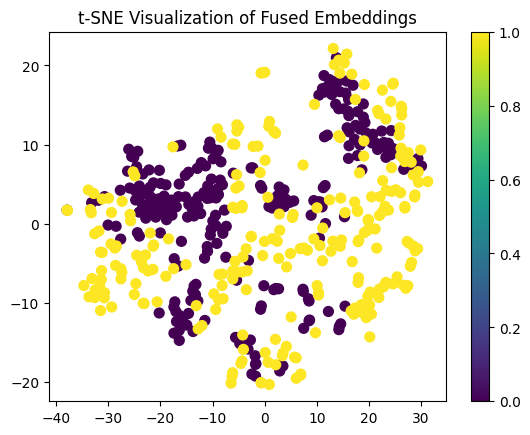

In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(fused_embeddings.detach().numpy())

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels_tensor.numpy(), cmap='viridis', s=50)
plt.colorbar()
plt.title("t-SNE Visualization of Fused Embeddings")
plt.show()

In [70]:
import torch.nn.functional as F

# Define a simple classifier
class Classifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(in_channels, num_classes)  # Fully connected layer

    def forward(self, x):
        return F.log_softmax(self.fc(x), dim=1)  # Apply softmax to get class probabilities

# Initialize the classifier
num_classes = len(labels.unique())  # Number of unique classes (e.g., 2 for Control and PD)
classifier = Classifier(in_channels=fused_embeddings.shape[1], num_classes=num_classes)

# Convert labels to tensor
labels_tensor = torch.tensor(labels.factorize()[0], dtype=torch.long)  # Convert labels to numerical values

# Forward pass through the classifier
predictions = classifier(fused_embeddings)  # Shape: (N, num_classes)

# Compute the classification loss (cross-entropy loss)
loss_classification = F.nll_loss(predictions, labels_tensor)

# Display the classification loss
print("Classification Loss:", loss_classification.item())

Classification Loss: 0.6891224384307861


In [71]:
import torch.optim as optim

# Define the overall loss function
def combined_loss(contrastive_loss, classification_loss, beta=0.5):
    """
    Combine contrastive loss and classification loss into a single objective function.

    Args:
        contrastive_loss (torch.Tensor): The contrastive loss value.
        classification_loss (torch.Tensor): The classification loss value.
        beta (float): Weighting factor for the contrastive loss (0 <= beta <= 1).

    Returns:
        torch.Tensor: The combined loss.
    """
    return beta * contrastive_loss + (1 - beta) * classification_loss

# Initialize optimizer
optimizer = optim.Adam(
    list(image_gat.parameters()) + list(clinical_gat.parameters()) + list(classifier.parameters()),
    lr=0.001
)

# Training loop
num_epochs = 200
beta = 0.5  # Weighting factor for contrastive loss

for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass through GATs
    image_embeddings = image_gat(image_graph)
    clinical_embeddings = clinical_gat(clinical_graph)

    # Fuse the embeddings
    fused_image_embeddings = activation(fusion_image_fc(image_embeddings))
    fused_clinical_embeddings = activation(fusion_clinical_fc(clinical_embeddings))
    fused_embeddings = fused_image_embeddings + fused_clinical_embeddings

    # Compute contrastive loss
    loss_contrastive = contrastive_loss(fused_embeddings, labels_tensor)

    # Forward pass through the classifier
    predictions = classifier(fused_embeddings)

    # Compute classification loss
    loss_classification = F.nll_loss(predictions, labels_tensor)

    # Compute combined loss
    loss = combined_loss(loss_contrastive, loss_classification, beta=beta)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Contrastive Loss: {loss_contrastive.item():.4f}, "
          f"Classification Loss: {loss_classification.item():.4f}, Combined Loss: {loss.item():.4f}")

Epoch 1/200, Contrastive Loss: 1.1660, Classification Loss: 0.6891, Combined Loss: 0.9276
Epoch 2/200, Contrastive Loss: 1.1268, Classification Loss: 0.6850, Combined Loss: 0.9059
Epoch 3/200, Contrastive Loss: 1.0910, Classification Loss: 0.6809, Combined Loss: 0.8860
Epoch 4/200, Contrastive Loss: 1.0585, Classification Loss: 0.6769, Combined Loss: 0.8677
Epoch 5/200, Contrastive Loss: 1.0283, Classification Loss: 0.6731, Combined Loss: 0.8507
Epoch 6/200, Contrastive Loss: 0.9995, Classification Loss: 0.6693, Combined Loss: 0.8344
Epoch 7/200, Contrastive Loss: 0.9716, Classification Loss: 0.6656, Combined Loss: 0.8186
Epoch 8/200, Contrastive Loss: 0.9448, Classification Loss: 0.6622, Combined Loss: 0.8035
Epoch 9/200, Contrastive Loss: 0.9194, Classification Loss: 0.6592, Combined Loss: 0.7893
Epoch 10/200, Contrastive Loss: 0.8952, Classification Loss: 0.6563, Combined Loss: 0.7757
Epoch 11/200, Contrastive Loss: 0.8717, Classification Loss: 0.6536, Combined Loss: 0.7627
Epoch 12

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate the model
def evaluate_model(fused_embeddings, labels_tensor, classifier):
    """
    Evaluate the model using accuracy, precision, recall, and F1-score.

    Args:
        fused_embeddings (torch.Tensor): Fused embeddings of shape (N, D).
        labels_tensor (torch.Tensor): True labels of shape (N,).
        classifier (torch.nn.Module): Trained classifier.

    Returns:
        None
    """
    # Forward pass through the classifier
    predictions = classifier(fused_embeddings)
    predicted_labels = predictions.argmax(dim=1).detach().numpy()  # Get predicted class labels
    true_labels = labels_tensor.numpy()  # Convert true labels to NumPy array

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Print evaluation metrics
    print("Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=labels.unique()))

# Evaluate the model
evaluate_model(fused_embeddings, labels_tensor, classifier)

Model Evaluation:
Accuracy: 0.9798
Precision: 0.9803
Recall: 0.9798
F1-Score: 0.9798

Classification Report:
              precision    recall  f1-score   support

     Control       0.96      1.00      0.98       240
          PD       1.00      0.96      0.98       254

    accuracy                           0.98       494
   macro avg       0.98      0.98      0.98       494
weighted avg       0.98      0.98      0.98       494



In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Split the dataset into training and test sets (80/20 split)
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
    fused_embeddings.detach().numpy(),  # Fused embeddings
    labels_tensor.numpy(),  # Labels
    test_size=0.2,  # 20% for testing
    random_state=42  # For reproducibility
)

# Convert training and test sets back to PyTorch tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float)
test_embeddings = torch.tensor(test_embeddings, dtype=torch.float)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Train the classifier on the training set
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 200  # You can adjust this
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = classifier(train_embeddings)
    loss = F.nll_loss(predictions, train_labels)
    loss.backward()
    optimizer.step()

# Evaluate the classifier on the test set
test_predictions = classifier(test_embeddings).argmax(dim=1).detach().numpy()
test_labels = test_labels.numpy()

# Compute evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print evaluation metrics
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=labels.unique()))

Test Set Evaluation:
Accuracy: 0.9899
Precision: 0.9901
Recall: 0.9899
F1-Score: 0.9899

Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.98      0.99        49
          PD       0.98      1.00      0.99        50

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



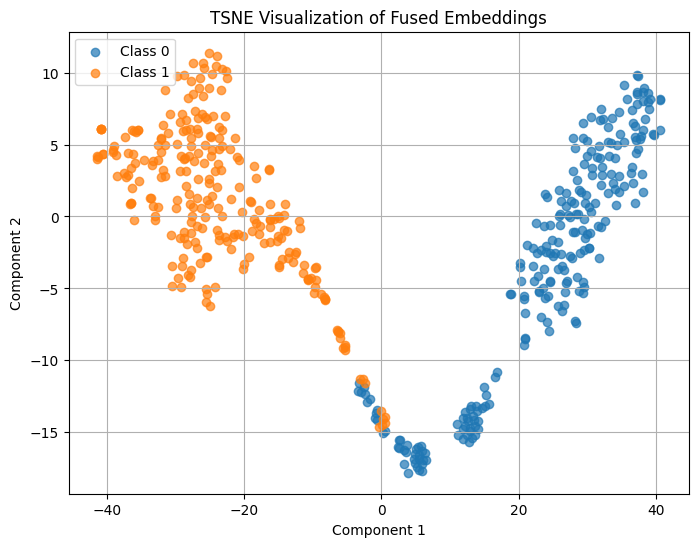

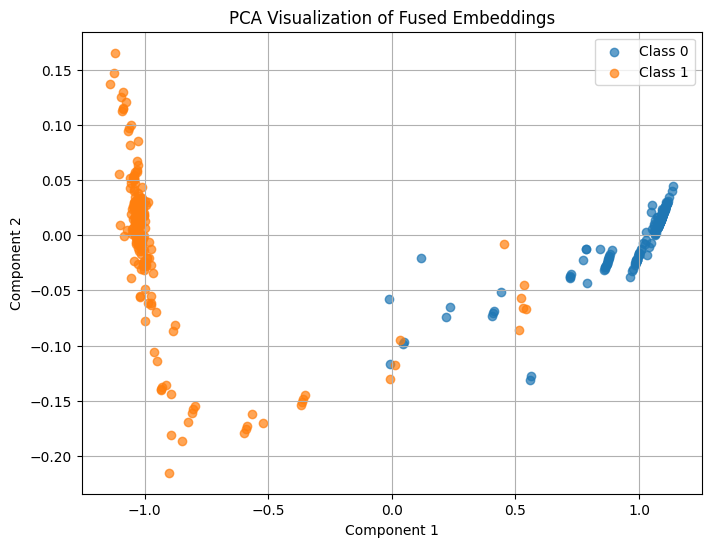

In [77]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Visualize embeddings using t-SNE
def visualize_embeddings(embeddings, labels, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Class {label}", alpha=0.7)
    plt.title(f"{method.upper()} Visualization of Fused Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
visualize_embeddings(fused_embeddings.detach().numpy(), labels_tensor.numpy(), method='tsne')
visualize_embeddings(fused_embeddings.detach().numpy(), labels_tensor.numpy(), method='pca')

In [79]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances
import numpy as np

# Function to compute cluster separability metrics
def analyze_embeddings(embeddings, labels, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    # Reduce embeddings to 2D
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Compute Silhouette Score
    silhouette = silhouette_score(reduced_embeddings, labels)
    
    # Compute Intra-cluster and Inter-cluster Distances
    intra_distances = []
    inter_distances = []
    for label in np.unique(labels):
        # Points in the current cluster
        cluster_points = reduced_embeddings[labels == label]
        
        # Intra-cluster distance (average pairwise distance within the cluster)
        intra_dist = np.mean(pairwise_distances(cluster_points))
        intra_distances.append(intra_dist)
        
        # Inter-cluster distance (distance to other clusters)
        other_points = reduced_embeddings[labels != label]
        inter_dist = np.mean(pairwise_distances(cluster_points, other_points))
        inter_distances.append(inter_dist)
    
    # Print metrics
    print(f"\n{method.upper()} Analysis of Fused Embeddings:")
    print(f"Silhouette Score: {silhouette:.4f}")
    for i, label in enumerate(np.unique(labels)):
        print(f"Class {label}: Intra-cluster Distance = {intra_distances[i]:.4f}, Inter-cluster Distance = {inter_distances[i]:.4f}")

# Call the function for t-SNE and PCA
analyze_embeddings(fused_embeddings.detach().numpy(), labels_tensor.numpy(), method='tsne')
analyze_embeddings(fused_embeddings.detach().numpy(), labels_tensor.numpy(), method='pca')


TSNE Analysis of Fused Embeddings:
Silhouette Score: 0.6674
Class 0: Intra-cluster Distance = 16.4223, Inter-cluster Distance = 48.8437
Class 1: Intra-cluster Distance = 12.9956, Inter-cluster Distance = 48.8437

PCA Analysis of Fused Embeddings:
Silhouette Score: 0.8903
Class 0: Intra-cluster Distance = 0.1520, Inter-cluster Distance = 1.9591
Class 1: Intra-cluster Distance = 0.1903, Inter-cluster Distance = 1.9591
